In [33]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/MyDrive/vision_data

/content/gdrive/MyDrive/vision_data


In [34]:
%cd gdrive/MyDrive/iemocap

[Errno 2] No such file or directory: 'gdrive/MyDrive/iemocap'
/content/gdrive/MyDrive/iemocap


In [35]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, LSTM, BatchNormalization, Input, concatenate, Activation, Concatenate, Bidirectional
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [36]:
lbl_impro = ["ses1/impro",
         "ses2/impro",
         "ses3/impro",
         "ses4/impro",
         "ses5/impro"]
lbl_script = ["ses1/script",
              "ses2/script",
              "ses3/script"
              "ses4/script"
              "ses5/script"]
n_part = 100

In [ ]:
directories = ["ses1/MOCAP_rotated",
         "ses2/MOCAP_rotated",
         "ses3/MOCAP_rotated",
         "ses4/MOCAP_rotated",
         "ses5/MOCAP_rotated"]

def read_MOCAP(root,f):
  data = pd.read_csv(os.path.join(root,f), sep=" ", encoding = 'unicode_escape', header=2)
  first_row = list(data.columns)
  first_row = clean_first_row(first_row)
  data.loc[0] = list(map(float,first_row))
  data.columns = list(np.arange(len(data.columns)))
  key = f.replace('.txt','')
  return data,key

def clean_first_row(row):
  clean_row = []
  for i in row:
    sp = i.split('.')
    if sp[0] == 'NaN':
      clean_row.append(sp[0])
    elif len(sp) > 2:
      clean_row.append(sp[0] + '.' + sp[1])
    else:
      clean_row.append(i)
  return clean_row

dfs = {}
for d in directories:
  for root,dir,list_f in os.walk(d):
    if 'script' in root:
      continue
    for f in list_f:
      print(f)
      data,key = read_MOCAP(root,f)
      dfs[key] = (data)


Ses01F_impro03_F021.txt
Ses01F_impro03_F009.txt
Ses01F_impro03_F010.txt
Ses01F_impro03_M001.txt
Ses01F_impro03_F014.txt
Ses01F_impro03_F016.txt
Ses01F_impro03_M016.txt
Ses01F_impro03_F001.txt
Ses01F_impro03_M018.txt
Ses01F_impro03_M005.txt
Ses01F_impro03_M010.txt
Ses01F_impro03_F002.txt
Ses01F_impro03_F011.txt
Ses01F_impro03_M015.txt
Ses01F_impro03_M024.txt
Ses01F_impro03_F015.txt
Ses01F_impro03_F020.txt
Ses01F_impro03_F003.txt
Ses01F_impro03_M022.txt
Ses01F_impro03_M008.txt
Ses01F_impro03_F026.txt
Ses01F_impro03_F012.txt
Ses01F_impro03_M006.txt
Ses01F_impro03_M014.txt
Ses01F_impro03_F006.txt
Ses01F_impro03_F000.txt
Ses01F_impro03_M000.txt
Ses01F_impro03_M019.txt
Ses01F_impro03_F023.txt
Ses01F_impro03_M023.txt
Ses01F_impro03_F013.txt
Ses01F_impro03_F025.txt
Ses01F_impro03_M021.txt
Ses01F_impro03_F008.txt
Ses01F_impro03_M012.txt
Ses01F_impro03_F019.txt
Ses01F_impro03_M020.txt
Ses01F_impro03_M004.txt
Ses01F_impro03_M013.txt
Ses01F_impro03_M017.txt
Ses01F_impro03_M007.txt
Ses01F_impro03_F

In [ ]:

def read_labels(root,f):
  file = open(os.path.join(root,f), 'r').read()
  data = np.array(file.split('\n'))
  idx = data == ''
  idx_n = np.arange(len(data))[idx]
  emotion = []
  for i in range(len(idx_n) - 2):
      g = data[idx_n[i]+1:idx_n[i+1]]
      head = g[0]
      i0 = head.find(' - ')
      start_time = float(head[head.find('[') + 1:head.find(' - ')])
      end_time = float(head[head.find(' - ') + 3:head.find(']')])
      actor_id = head[head.find(f[:-4]) + len(f[:-4]) + 1:
                      head.find(f[:-4]) + len(f[:-4]) + 5]
      emo = head[head.find('\t[') - 3:head.find('\t[')]
      vad = head[head.find('\t[') + 1:]
      if emo == 'exc':
        emo = 'hap'
      v = float(vad[1:7])
      a = float(vad[9:15])
      d = float(vad[17:23])

      j = 1
      emos = []
      while g[j][0] == "C":
        head = g[j]
        start_idx = head.find("\t") + 1
        evoluator_emo = []
        idx = head.find(";", start_idx)
        while idx != -1:
          evoluator_emo.append(head[start_idx:idx].strip().lower()[:3])
          start_idx = idx + 1
          idx = head.find(";", start_idx)
        emos.append(evoluator_emo)
        j += 1

      emotion.append({'start': start_time,
                        'end': end_time,
                        'id': f[:-4] + '_' + actor_id,
                        'v': v,
                        'a': a,
                        'd': d,
                        'emotion': emo,
                        'emo_evo': emos})
  return emotion

lbls = []

for d in lbl_impro:
  for root,dir,list_f in os.walk(d):
    for f in list_f:
      emotions = read_labels(root,f)
      for e in emotions:
        lbls.append(e)


In [ ]:
#assigning labeles and dropping useless ones
def usefull_labels(lbl):
    if lbl['emotion'] in ['ang','hap','neu','sad'] and lbl['id'].split('_')[0][-1] == lbl['id'].split('_')[2][0] and lbl['id'] in dfs.keys():
      return True
    return False

def useless_Mocap(dfs,lbls):
  used_data = {}
  ids = []
  for lbl in lbls:
    ids.append(lbl['id'])

  for id in ids:
    used_data[id] = dfs[id].copy()
  return used_data

used_lbls = []
for lbl in lbls:
  if usefull_labels(lbl):
    used_lbls.append(lbl)

used_data = useless_Mocap(dfs,used_lbls)

In [ ]:
print(dfs['Ses01M_impro04_M005'])

In [ ]:
#partitioning of the arrays

def partition_data(dff,num_partition):
  parts = []
  means = []
  cnt = 0
  periods = np.linspace(float(dff[1].iloc[0]),float(dff[1].iloc[-1]),num=num_partition,endpoint = False)
  dist = (float(dff[1].iloc[-1]) - float(dff[1].iloc[0]))/(num_partition-1)
  for p in periods:
    parts.append(dff[(pd.to_numeric(dff[1]) >= p) & (pd.to_numeric(dff[1]) < p + dist)])
  for p in parts:
    means.append(p.astype('float').mean())
  partitioned_df = pd.concat(means,axis = 1)
  partitioned_df = partitioned_df.T
  partitioned_df = partitioned_df.drop([0,1],axis=1)
  partitioned_df.fillna(0, inplace = True)
  # partitioned_df = scale(partitioned_df,axis = 0)

  return partitioned_df

train_data = {}
train_labels = {}
for lbl in used_lbls:
  train_data[lbl['id']] = partition_data(used_data[lbl['id']],n_part)
  train_labels[lbl['id']] = lbl['emotion']


In [ ]:
# with open('mocap_data_vision_preprocessed.pickle', 'wb') as handle:
#   pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('mocap_data_vision_preprocessed_annorm.pickle', 'wb') as handle:
#   pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('labels.pickle', 'wb') as handle:
#   pickle.dump(train_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
with open('mocap_data_vision_preprocessed_annorm.pickle', 'rb') as handle:
  train_data_annorm = pickle.load(handle)

In [38]:
with open('mocap_data_vision_preprocessed.pickle', 'rb') as handle:
  train_data = pickle.load(handle)

In [39]:
with open('labels.pickle', 'rb') as handle:
  train_labels = pickle.load(handle)

In [40]:
with open('mocap_face_feature_collected_s12345.pickle', 'rb') as handle:
  audio_train_data = pickle.load(handle)

In [ ]:
#fold creation
folds_vision_tr = []
folds_audio_tr = []
folds_labels_tr = []
folds_vision_te = []
folds_audio_te = []
folds_labels_te = []
for i in range(5):
  fold_vis_te = []
  fold_aud_te = []
  fold_lbls_te = []
  fold_vis_tr = []
  fold_aud_tr = []
  fold_lbls_tr = []
  for id in train_data.keys():
    if id.startswith('Ses0' + str(i+1)):
      fold_vis_te.append(train_data[id])
      fold_aud_te.append(audio_train_data[id])
      fold_lbls_te.append(train_labels[id])
    else:
      fold_vis_tr.append(train_data[id])
      fold_aud_tr.append(audio_train_data[id])
      fold_lbls_tr.append(train_labels[id])

  folds_vision_tr.append(fold_vis_tr)
  folds_audio_tr.append(fold_aud_tr)
  folds_labels_tr.append(fold_lbls_tr)
  folds_vision_te.append(fold_vis_te)
  folds_audio_te.append(fold_aud_te)
  folds_labels_te.append(fold_lbls_te)


In [ ]:
Xs_vis_tr = []
Xs_aud_tr = []
Ys_tr = []
Xs_vis_te = []
Xs_aud_te = []
Ys_te = []

for i in range(5):
  X_vis_tr = np.stack(folds_vision_tr[i])
  X_aud_tr = np.stack(folds_audio_tr[i])
  Y_tr = np.stack(folds_labels_tr[i])
  X_vis_te = np.array(folds_vision_te[i])
  X_aud_te = np.array(folds_audio_te[i])
  Y_te = np.array(folds_labels_te[i])

  Y_tr = Y_tr.reshape(-1,1)
  Y_te = Y_te.reshape(-1,1)
  onehotencoder = OneHotEncoder()
  Y_tr = onehotencoder.fit_transform(Y_tr).toarray()
  Y_te = onehotencoder.fit_transform(Y_te).toarray()

  Xs_vis_tr.append(X_vis_tr)
  Xs_aud_tr.append(X_aud_tr)
  Ys_tr.append(Y_tr)
  Xs_vis_te.append(X_vis_te)
  Xs_aud_te.append(X_aud_te)
  Ys_te.append(Y_te)



In [ ]:
#define model
def cnn_model(input_shape):
  model = Sequential()

  model.add(Conv2D(filters=32,kernel_size=3,activation='relu',strides = (2,2),input_shape=input_shape))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=64,kernel_size=3,activation='relu',strides = (2,2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=64,kernel_size=3,activation='relu',strides = (2,2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=128,kernel_size=3,activation='relu',strides = (2,2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=128,kernel_size=3,activation='relu',strides = (2,2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  # model.add(Dense(256,activation='relu'))
  model.add(Dense(64,activation='relu'))
  model.add(Dense(4,activation='softmax'))

  return model


In [ ]:
def build_model0(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(256, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(128))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(4, activation='softmax'))

    return model

In [ ]:
def build_model1(input_shape):
    model = tf.keras.Sequential()

    model.add(Flatten(input_shape = input_shape))
    model.add(Dense(256, activation='relu'))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(4, activation='softmax'))

    return model

In [ ]:
def build_model3(input_shape):
    model_speech = tf.keras.Sequential()
    model_speech.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout = 0.2), input_shape=input_shape))
    model_speech.add(Dropout(0.2))
    model_speech.add(Flatten())
    model_speech.add(Dense(256, activation='relu'))
    model_speech.add(Dropout(0.3))

    model_speech.add(Dense(4, activation='softmax'))

    return model_speech

In [41]:
history = []
models_vis = []
for i in range(5):
  model = cnn_model((n_part,165,1))
  model.compile(loss ='categorical_crossentropy', optimizer=Adam(learning_rate=0.001),metrics =['accuracy'])
  X,X_val,y,y_val = train_test_split(Xs_vis_tr[i],Ys_tr[i],test_size = 0.1)
  history.append(model.fit(
      X,
      y,
      batch_size=64,
      epochs=6,
      validation_data=(X_val,y_val),
  ))
  models_vis.append(model)

Epoch 1/6
 7/18 [==========>...................] - ETA: 7s - loss: 1.3563 - accuracy: 0.3348

KeyboardInterrupt: ignored

In [ ]:
def draw_loss(history,epoch):
  for h in history:
    loss_train = h.history['loss']
    loss_val = h.history['val_loss']
    epochs = range(1,epoch+1)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def draw_acc(history,epoch):
  for h in history:
    loss_train = h.history['accuracy']
    loss_val = h.history['val_accuracy']
    epochs = range(1,epoch+1)
    plt.plot(epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(epochs, loss_val, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

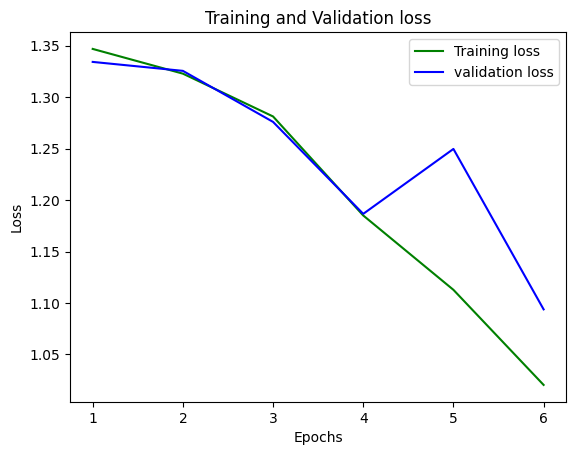

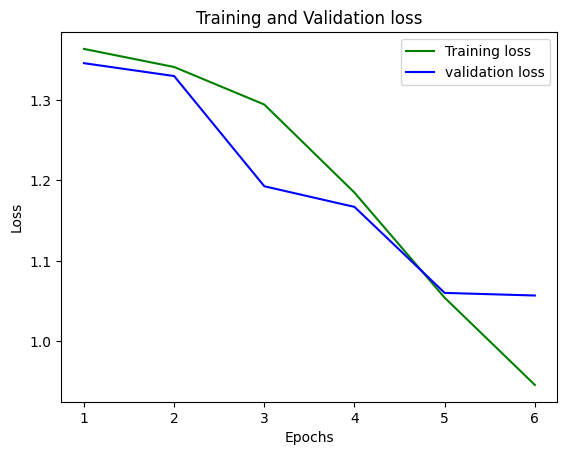

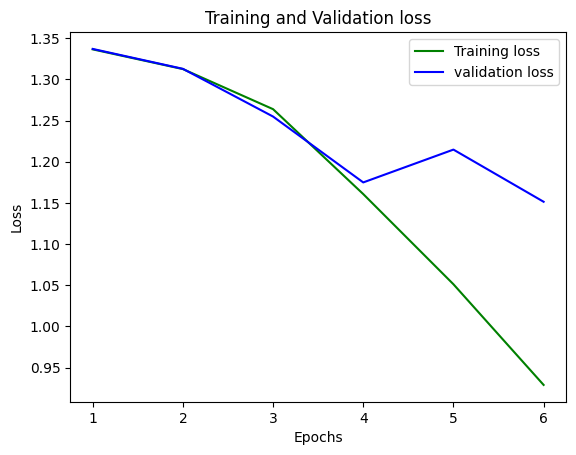

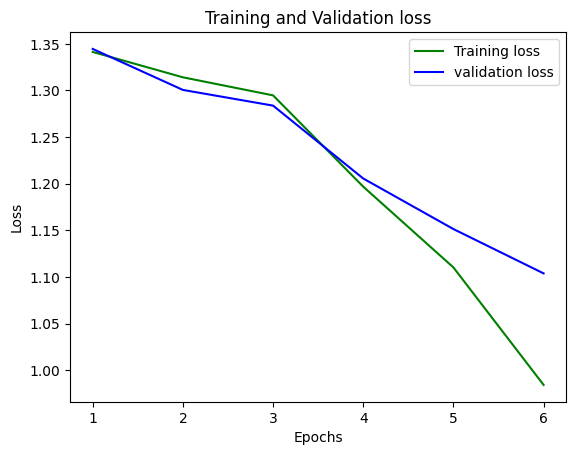

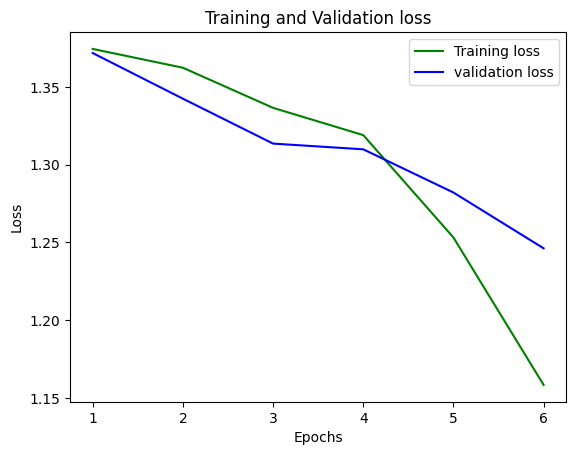

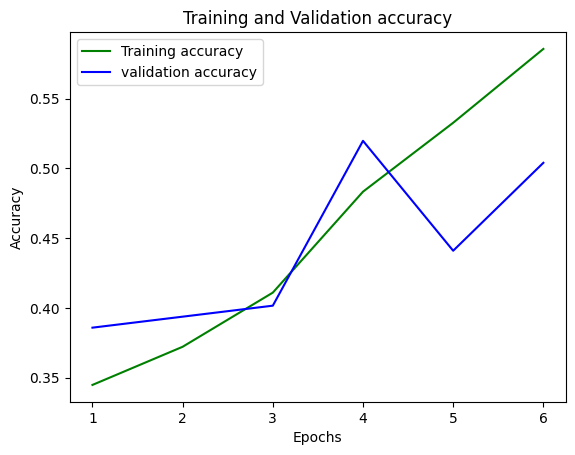

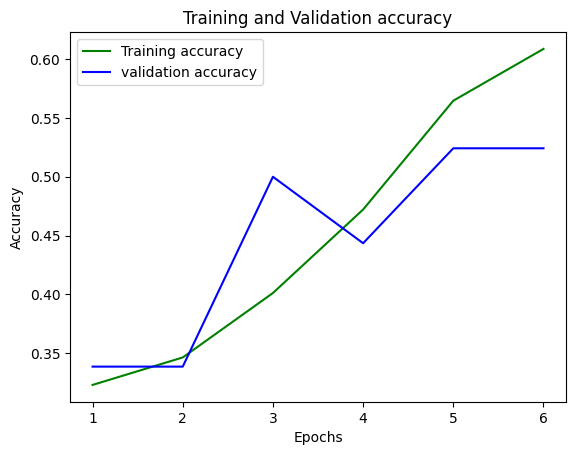

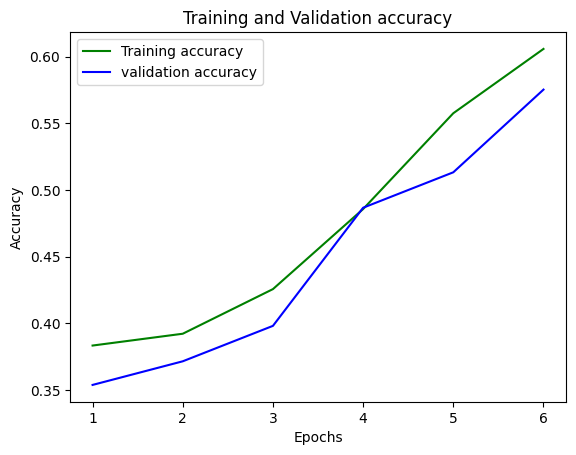

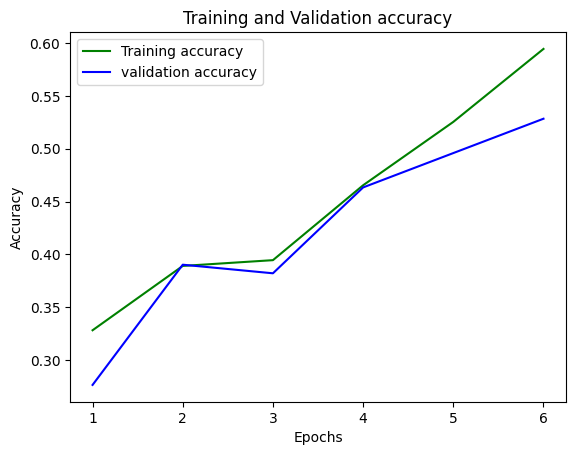

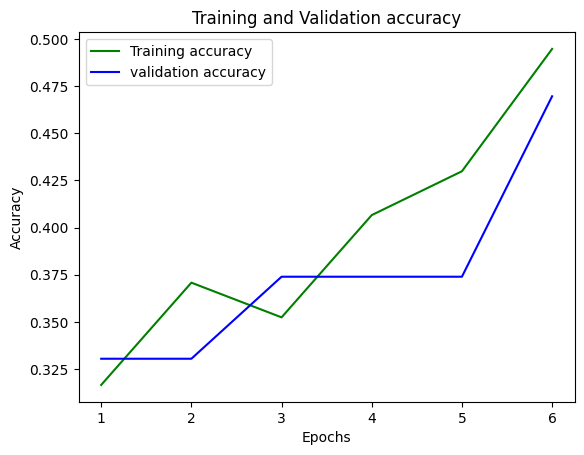

In [ ]:
draw_loss(history,6)
draw_acc(history,6)

In [ ]:
scores = []
preds_vis = []
for i in range(5):
  scores.append(models_vis[i].evaluate(Xs_vis_te[i],Ys_te[i]))
  preds_vis.append(models_vis[i].predict(Xs_vis_te[i]))

11/11 [==============================] - 1s 95ms/step


['ang', 'hap', 'neu', 'sad']


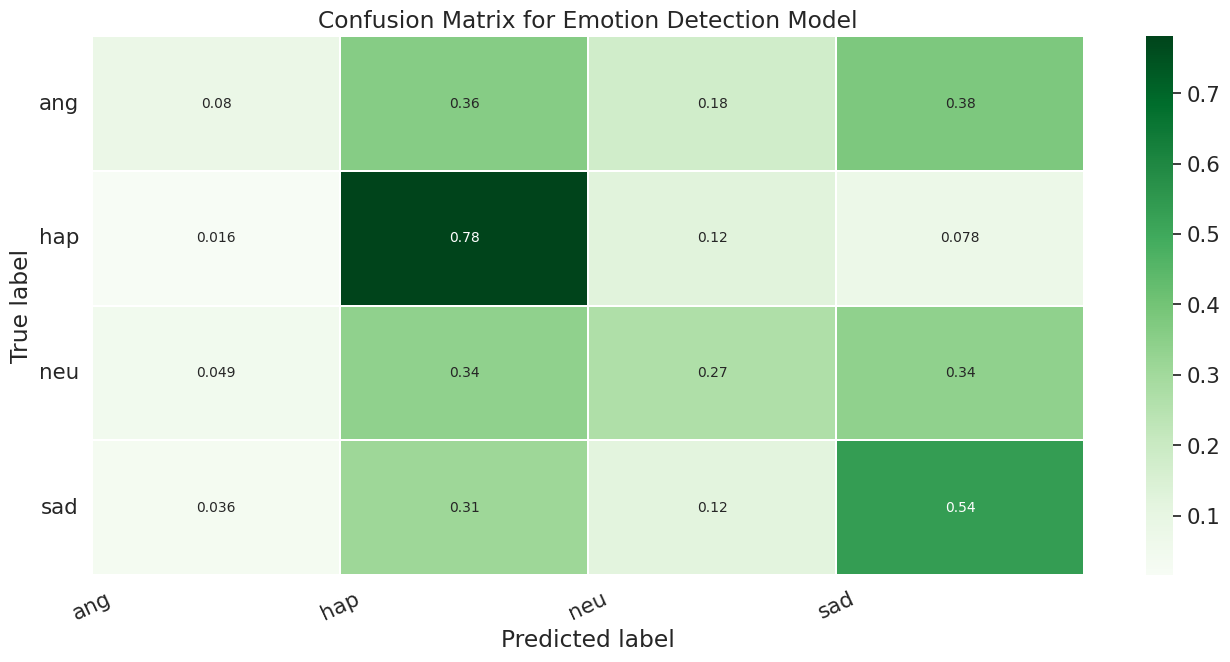

['ang', 'hap', 'neu', 'sad']


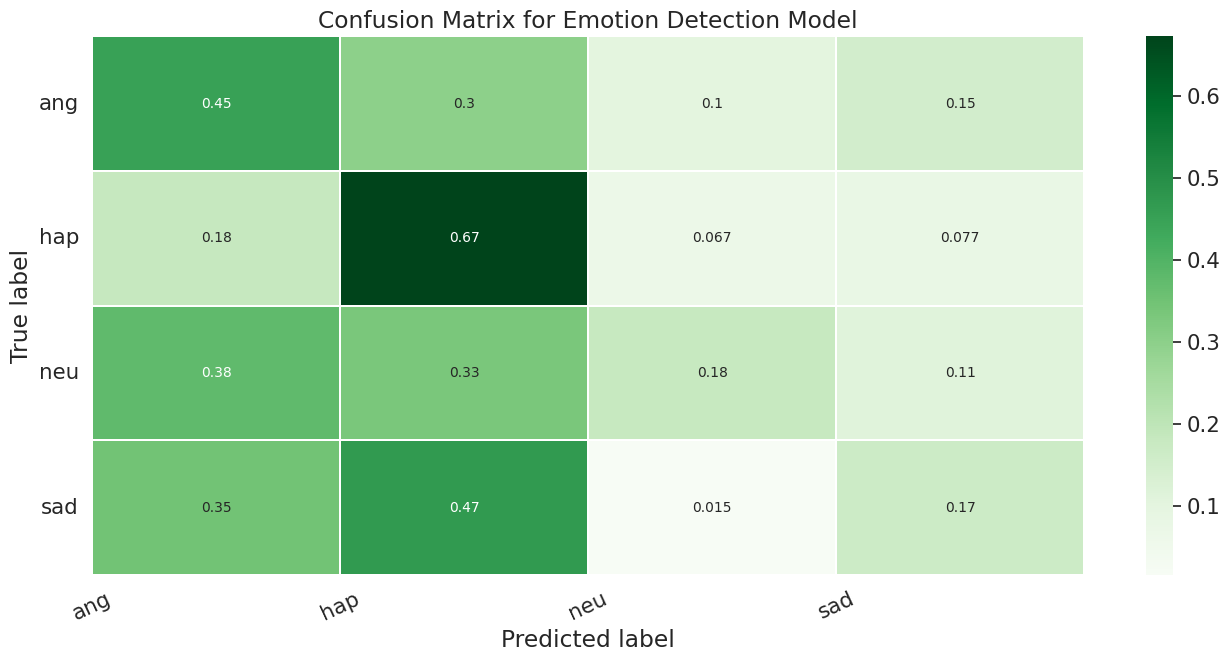

['ang', 'hap', 'neu', 'sad']


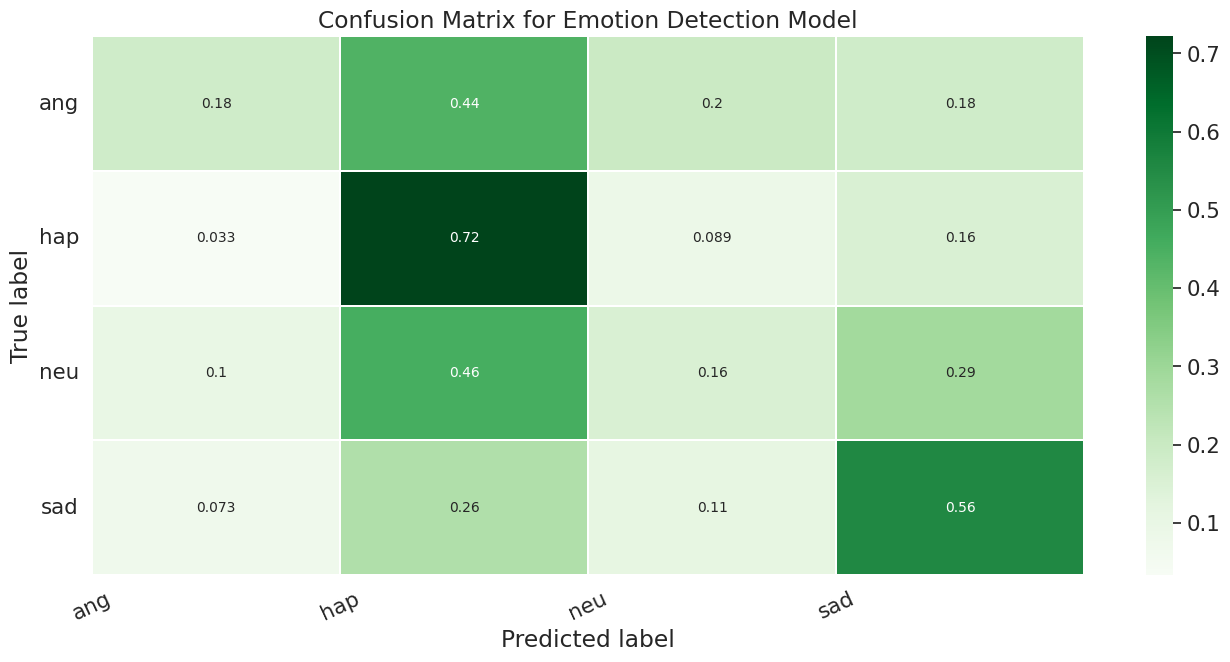

['ang', 'hap', 'neu', 'sad']


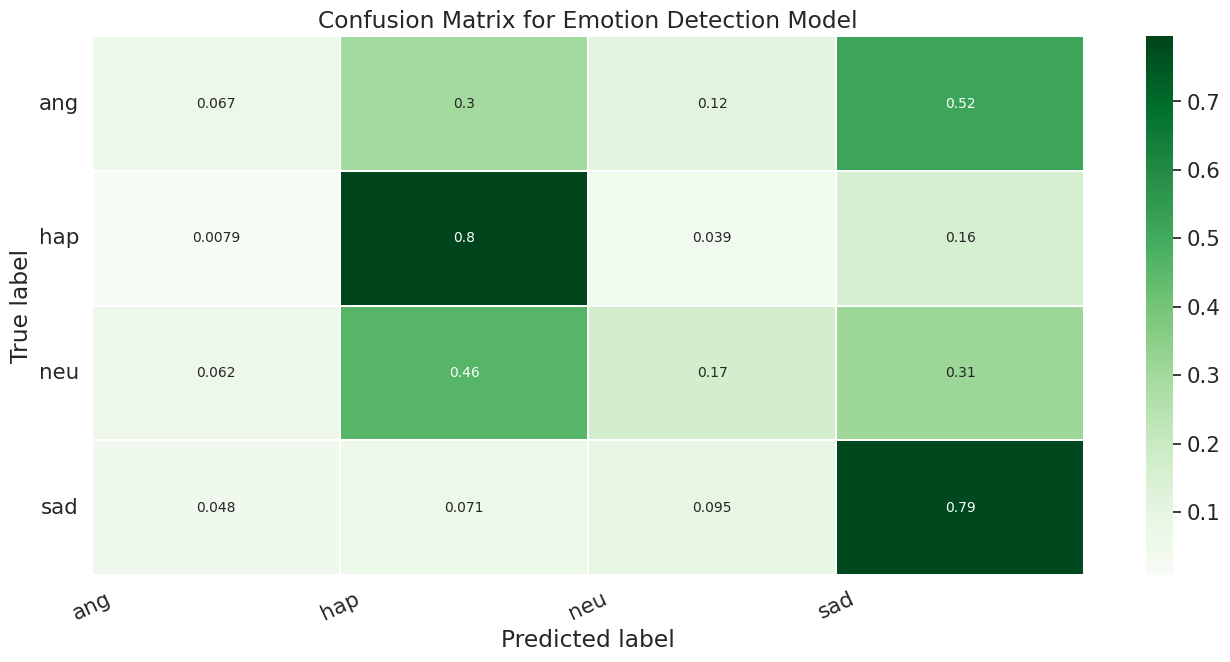

['ang', 'hap', 'neu', 'sad']


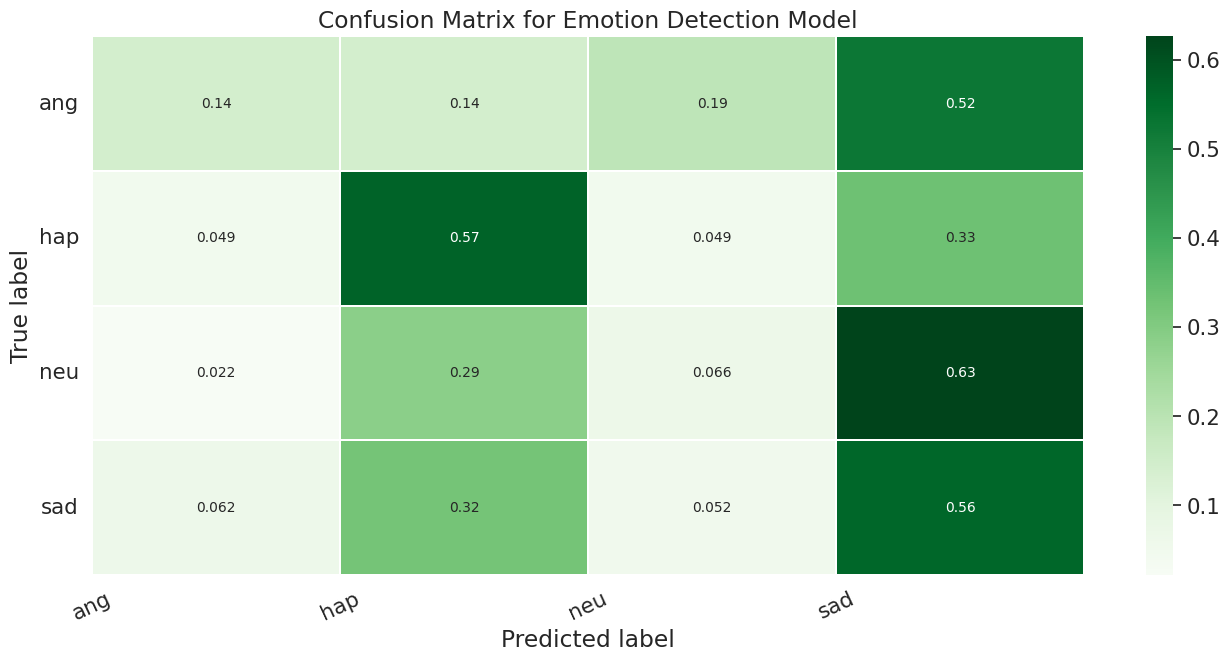

In [ ]:
for i in range(5):
  ploting_the_confusion_matrix(Ys_te[i], preds_vis[i], ['ang','hap','neu','sad'], unsupervised=False)

In [52]:
input_shape = (100,34)

# compile model
models_aud = []
history_audio = []
for i in range(5):
  print('--------- sesion',i+1,'---------')
  model = build_model3(input_shape)
  model.compile(optimizer=Adam(learning_rate=3e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  X,X_val,y,y_val = train_test_split(Xs_aud_tr[i],Ys_tr[i],test_size = 0.1)
  history_audio.append(model.fit(X, y, validation_data=(X_val, y_val), batch_size=64, epochs=20))
  models_aud.append(model)

--------- sesion 1 ---------
Epoch 1/20
18/18 [==============================] - 25s 846ms/step - loss: 1.6645 - accuracy: 0.3739 - val_loss: 1.2351 - val_accuracy: 0.3228
Epoch 2/20
18/18 [==============================] - 13s 749ms/step - loss: 1.1621 - accuracy: 0.5115 - val_loss: 1.1336 - val_accuracy: 0.5118
Epoch 3/20
18/18 [==============================] - 13s 757ms/step - loss: 1.0499 - accuracy: 0.5317 - val_loss: 0.9354 - val_accuracy: 0.5984
Epoch 4/20
18/18 [==============================] - 13s 748ms/step - loss: 0.9902 - accuracy: 0.5529 - val_loss: 0.9080 - val_accuracy: 0.5906
Epoch 5/20
18/18 [==============================] - 13s 736ms/step - loss: 0.9597 - accuracy: 0.5838 - val_loss: 0.9177 - val_accuracy: 0.6142
Epoch 6/20
18/18 [==============================] - 14s 758ms/step - loss: 0.9117 - accuracy: 0.5961 - val_loss: 0.8890 - val_accuracy: 0.6220
Epoch 7/20
18/18 [==============================] - 13s 685ms/step - loss: 0.8845 - accuracy: 0.6182 - val_loss: 

In [53]:
scores = []
preds_aud = []
for i in range(5):
  scores.append(models_aud[i].evaluate(Xs_aud_te[i],Ys_te[i]))
  preds_aud.append(models_aud[i].predict(Xs_aud_te[i]))

11/11 [==============================] - 1s 75ms/step


In [49]:
(0.6402+0.6450+0.5703+0.6282+0.5142)/5

0.5995800000000001

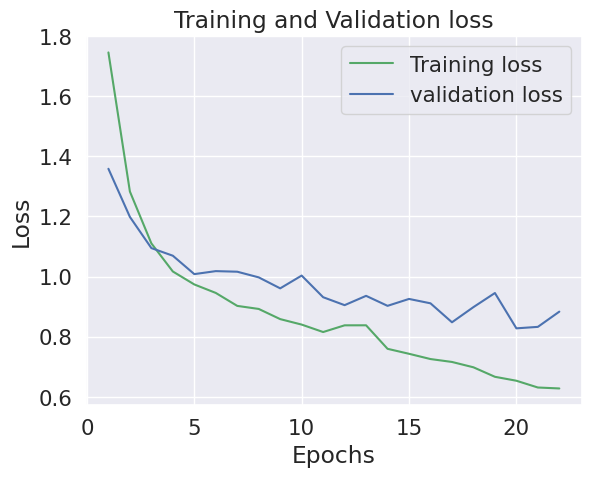

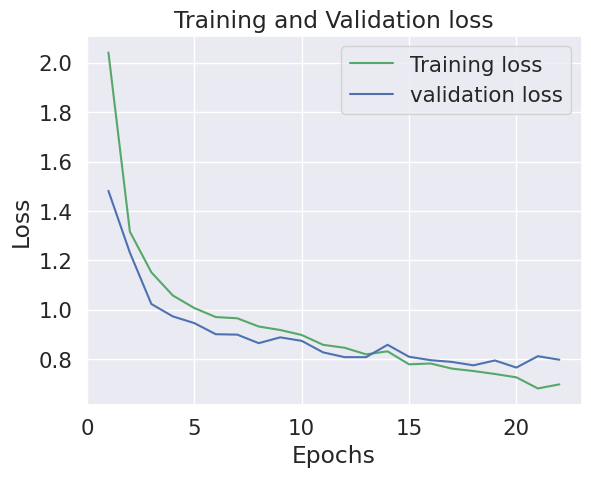

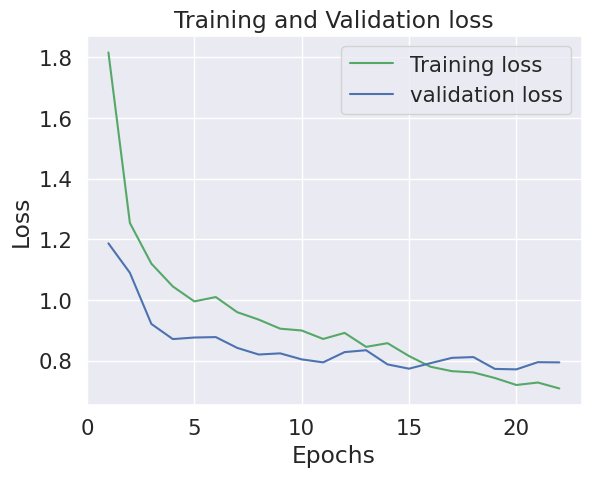

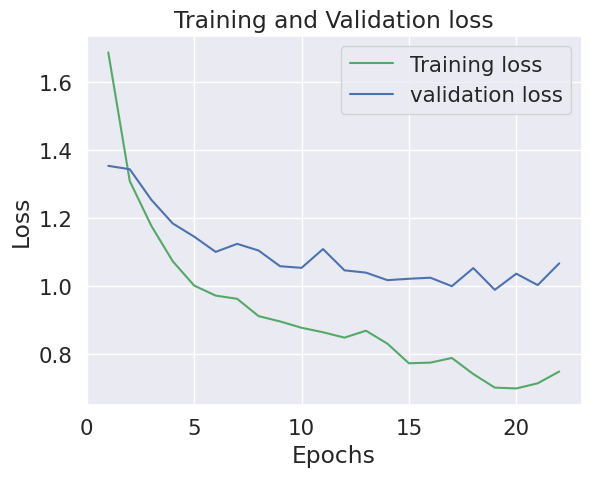

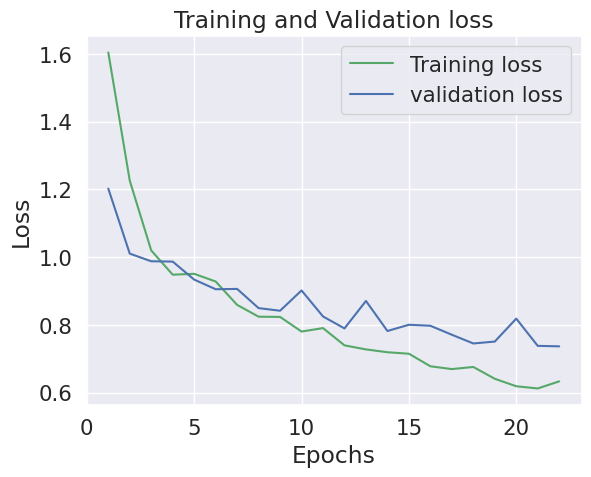

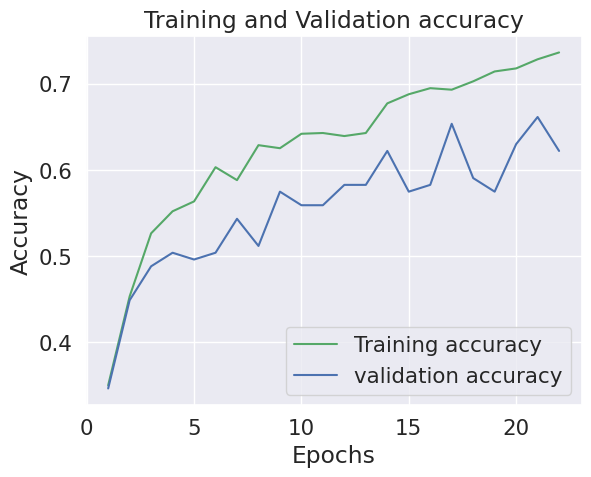

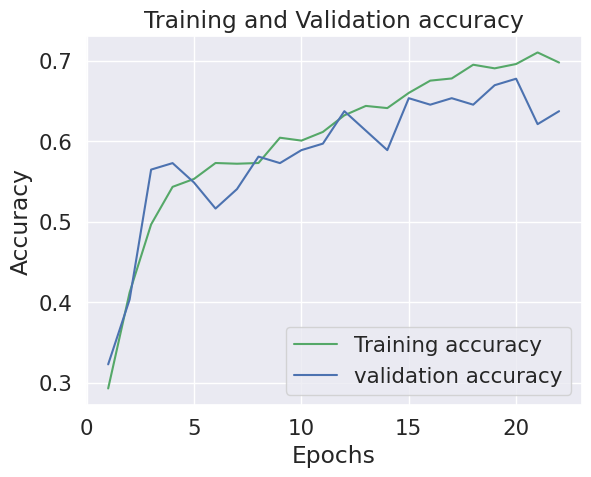

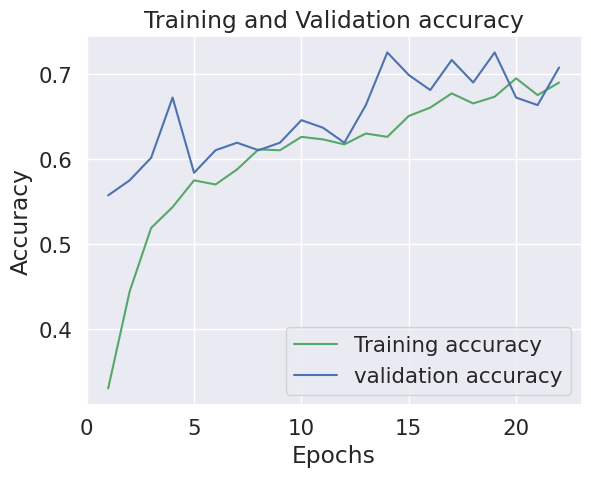

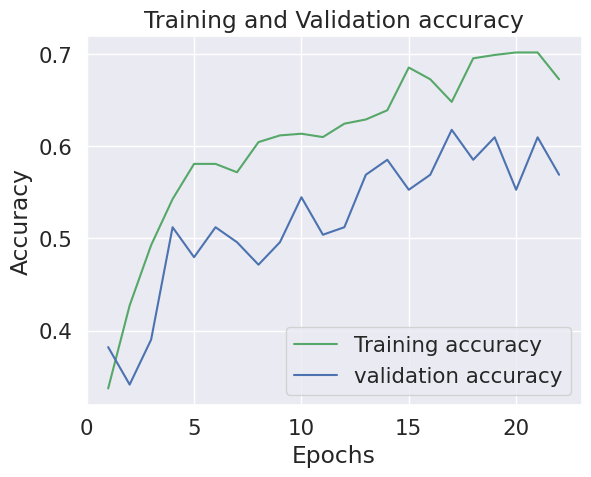

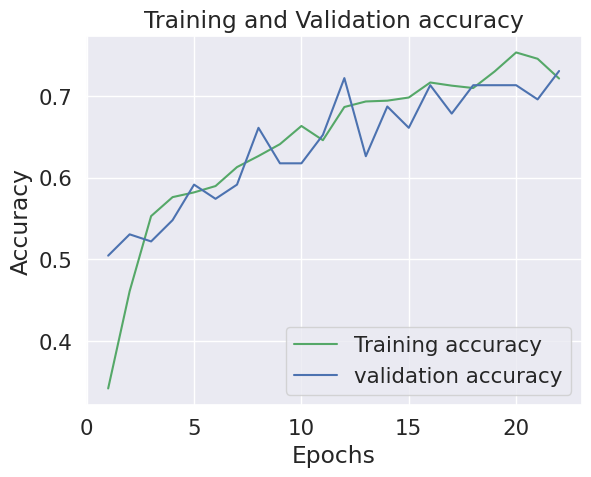

In [51]:
draw_loss(history_audio,20)
draw_acc(history_audio,20)

['ang', 'hap', 'neu', 'sad']


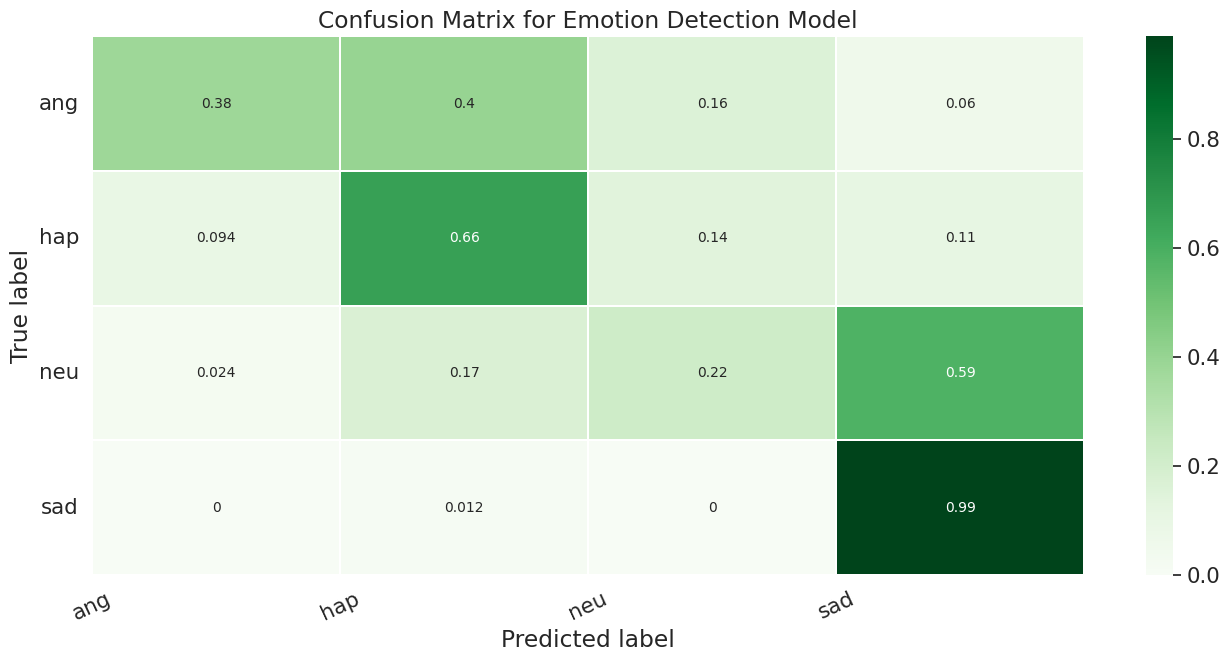

['ang', 'hap', 'neu', 'sad']


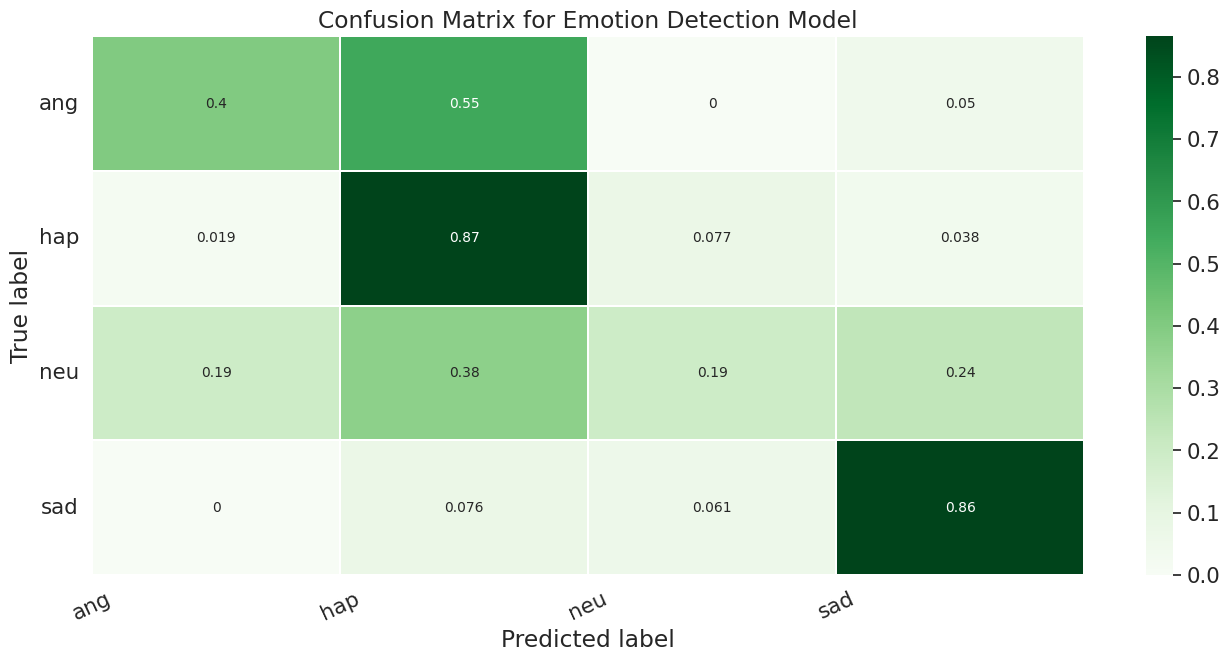

['ang', 'hap', 'neu', 'sad']


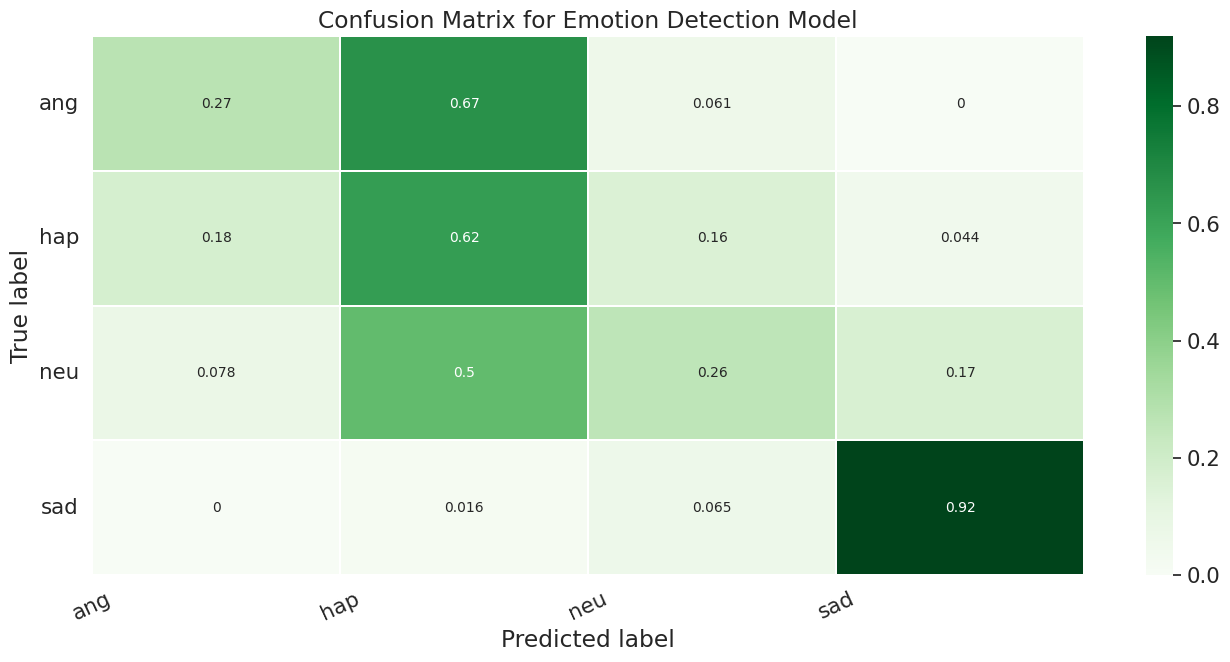

['ang', 'hap', 'neu', 'sad']


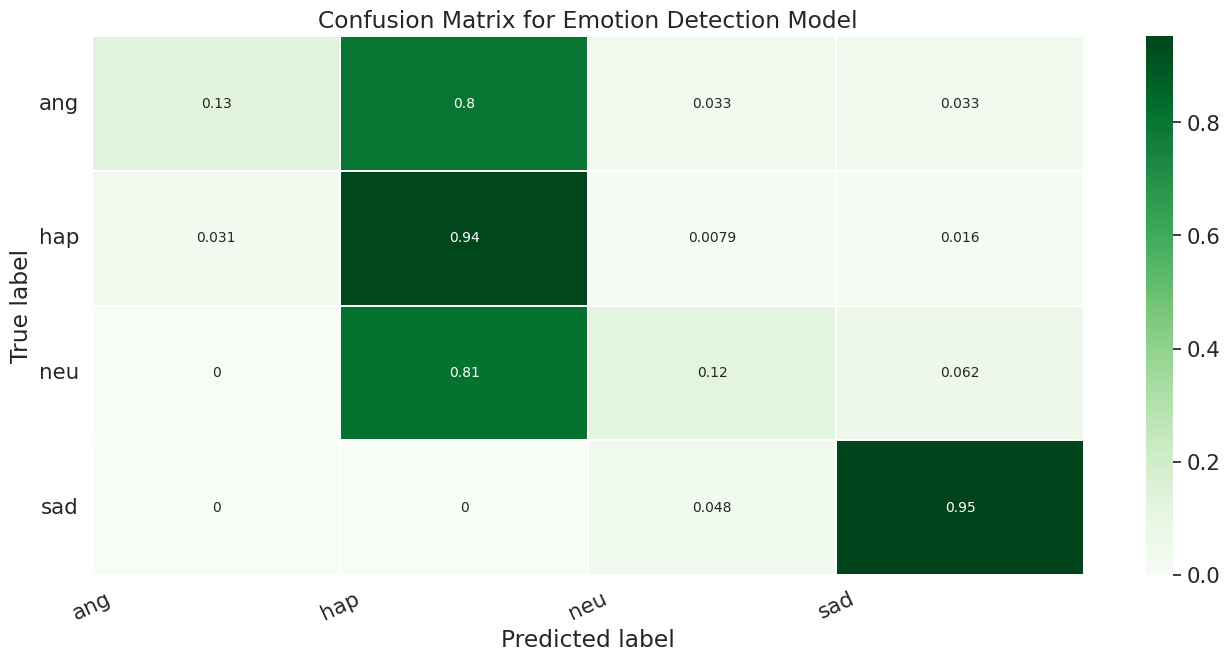

['ang', 'hap', 'neu', 'sad']


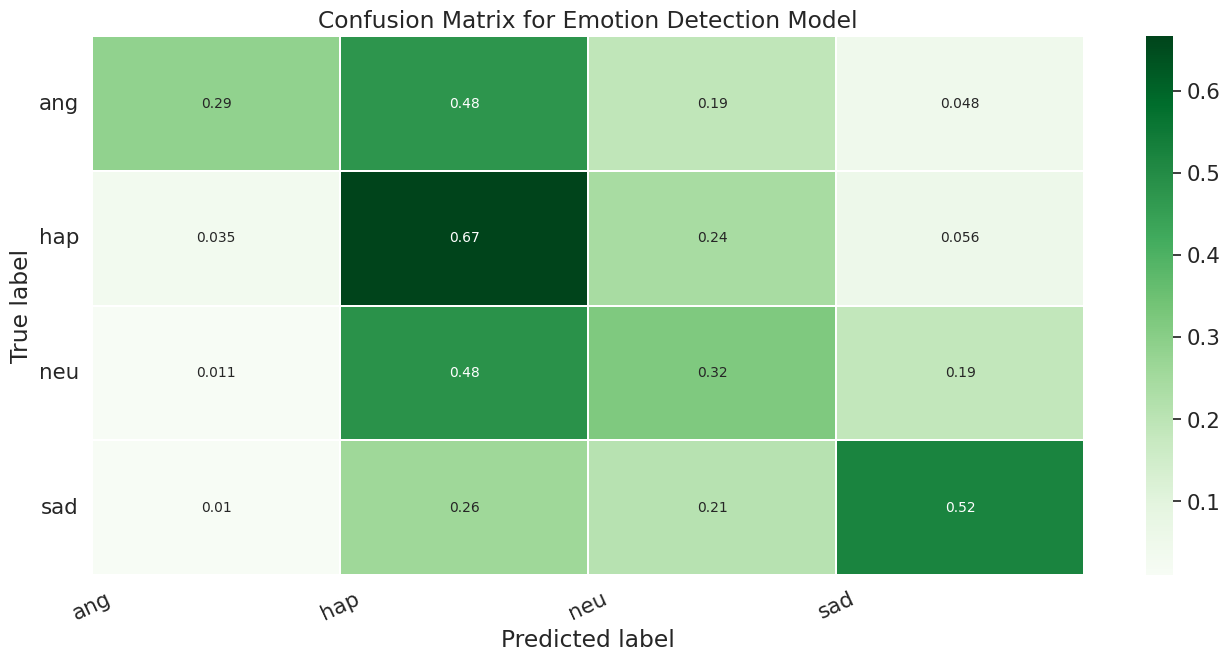

In [50]:
for i in range(5):
  ploting_the_confusion_matrix(Ys_te[i], preds_aud[i], ['ang','hap','neu','sad'], unsupervised=False)

In [ ]:
def combined_model0(input_shape_vis,input_shape_aud):

  input_vis = Input(input_shape_vis)

  x = Conv2D(filters=32,kernel_size=3,activation='relu',strides = (2,2)) (input_vis)
  x = Dropout(0.2) (x)
  x = Conv2D(filters=64,kernel_size=3,activation='relu',strides = (2,2)) (x)
  x = Dropout(0.2) (x)
  x = Conv2D(filters=64,kernel_size=3,activation='relu',strides = (2,2)) (x)
  x = Dropout(0.2) (x)
  x = Conv2D(filters=128,kernel_size=3,activation='relu',strides = (2,2)) (x)
  x = Dropout(0.2) (x)
  x = Conv2D(filters=128,kernel_size=3,activation='relu',strides = (2,2)) (x)
  x = Dropout(0.2) (x)
  x = Flatten() (x)
  x = Dense(64,activation='relu') (x)
  x = Model(inputs=input_vis, outputs=x)

  input_aud = Input(input_shape_aud)

  y = LSTM(128, return_sequences=True) (input_aud)
  y = LSTM(64) (y)
  y = Dense(64, activation='relu') (y)
  y = Model(inputs=input_aud, outputs=y)

  combined = concatenate([x.output, y.output])

  z = Dense(256, activation="relu")(combined)
  z = Dense(4, activation="softmax")(z)

  model = Model(inputs=[x.input, y.input], outputs=z)


  return model

In [ ]:
def combined_model2(input_shape_vis,input_shape_aud):

  input_vis = Input(input_shape_vis)

  model_vis = Sequential()

  model_vis.add(Conv2D(filters=32,kernel_size=3,activation='relu',strides = (2,2),input_shape=input_shape_vis))
  model_vis.add(Dropout(0.2))
  model_vis.add(Conv2D(filters=64,kernel_size=3,activation='relu',strides = (2,2)))
  model_vis.add(Dropout(0.2))
  model_vis.add(Conv2D(filters=64,kernel_size=3,activation='relu',strides = (2,2)))
  model_vis.add(Dropout(0.2))
  model_vis.add(Conv2D(filters=128,kernel_size=3,activation='relu',strides = (2,2)))
  model_vis.add(Dropout(0.2))
  model_vis.add(Conv2D(filters=128,kernel_size=3,activation='relu',strides = (2,2)))
  model_vis.add(Dropout(0.2))
  model_vis.add(Flatten())
  # model.add(Dense(256,activation='relu'))
  model_vis.add(Dense(64,activation='relu'))

  input_aud = Input(input_shape_aud)

  model_aud = tf.keras.Sequential()

  model_aud.add(LSTM(128, input_shape=input_shape_aud, return_sequences=True))
  model_aud.add(LSTM(64))

  model_aud.add(Dense(64, activation='relu'))

  model_combined = Sequential()
  model_combined = Concatenate()[model_vis, model_aud]

  model_combined.add(Activation('relu'))

  model_combined.add(Dense(256, activation="relu"))
  model_combined.add(Dense(4, activation="softmax"))

  return model_combined

In [ ]:
def combined_model1(model_vis,model_aud):

  input_vis = Input(input_shape_vis)

  vis_layer = Model(inputs=model_vis.input, outputs=model_vis.layers[-2].output)
  aud_layer = Model(inputs=model_aud.input, outputs=model_aud.layers[-2].output)

  combined = keras.layers.concatenate([vis_layer.output,
                        aud_layer.output])

  z = Dense(64, activation="relu")(combined) # 128, 64, 32
  last_layer = Dense(4, activation="softmax")(z)

  model = Model(inputs=[vis_layer.input, aud_layer.input], outputs=last_layer)

  return model

In [ ]:
input_shape_vis = (n_part, 165, 1)
input_shape_aud = (100, 34)

models_combined = []
history_combined = []
for i in range(5):
  print('--------- session',i+1,'---------')
  model = combined_model1(models_vis[i], models_aud[i])
  model.compile(optimizer=Adam(learning_rate=0.0003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  X_vis, X_val_vis, X_aud, X_val_aud, y, y_val = train_test_split(Xs_vis_tr[i],Xs_aud_tr[i],Ys_tr[i],test_size = 0.1)

  history_combined.append(model.fit([X_vis, X_aud], y, validation_data=([X_val_vis, X_val_aud], y_val), batch_size=64, epochs=8))
  models_combined.append(model)


--------- session 1 ---------
Epoch 1/8
18/18 [==============================] - 34s 2s/step - loss: 1.1890 - accuracy: 0.5229 - val_loss: 0.8046 - val_accuracy: 0.7008
Epoch 2/8
18/18 [==============================] - 25s 1s/step - loss: 0.7437 - accuracy: 0.7108 - val_loss: 0.6356 - val_accuracy: 0.7717
Epoch 3/8
18/18 [==============================] - 25s 1s/step - loss: 0.6518 - accuracy: 0.7460 - val_loss: 0.6874 - val_accuracy: 0.7795
Epoch 4/8
18/18 [==============================] - 23s 1s/step - loss: 0.5820 - accuracy: 0.7857 - val_loss: 0.6309 - val_accuracy: 0.7795
Epoch 5/8
18/18 [==============================] - 25s 1s/step - loss: 0.5576 - accuracy: 0.7998 - val_loss: 0.5942 - val_accuracy: 0.7953
Epoch 6/8
18/18 [==============================] - 25s 1s/step - loss: 0.4986 - accuracy: 0.8148 - val_loss: 0.5123 - val_accuracy: 0.7795
Epoch 7/8
18/18 [==============================] - 23s 1s/step - loss: 0.4656 - accuracy: 0.8192 - val_loss: 0.4996 - val_accuracy: 0.81

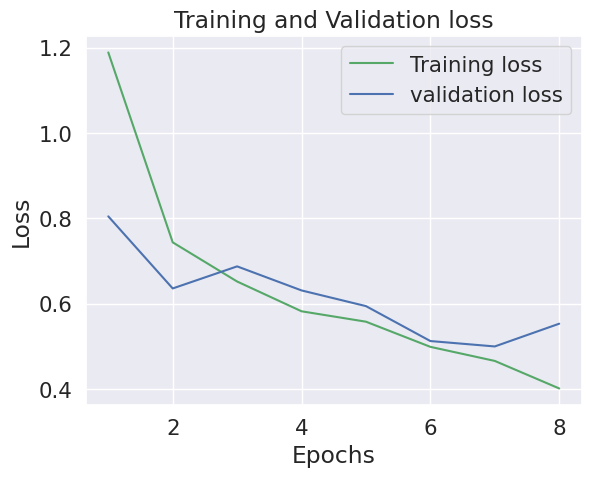

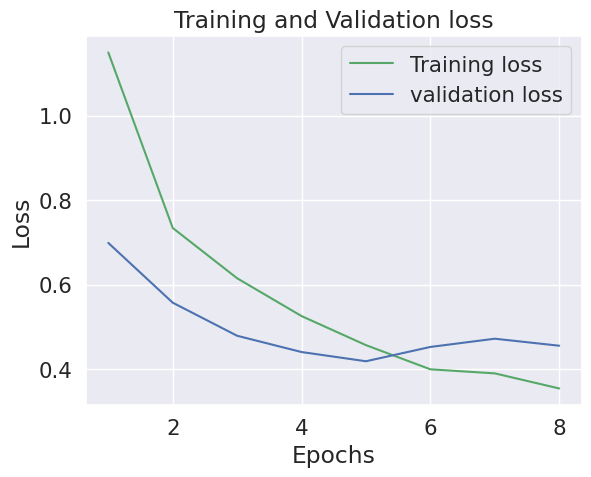

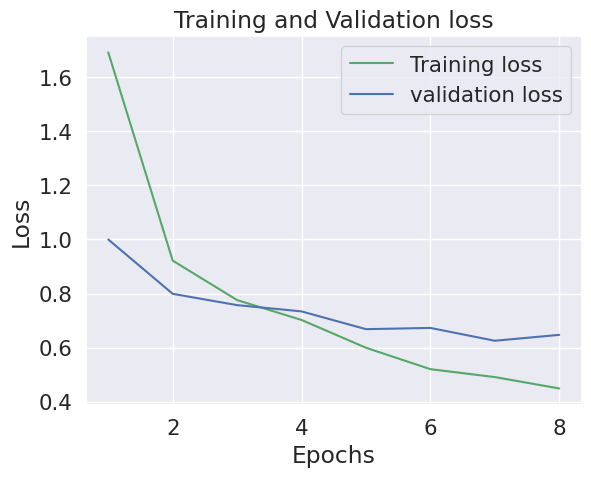

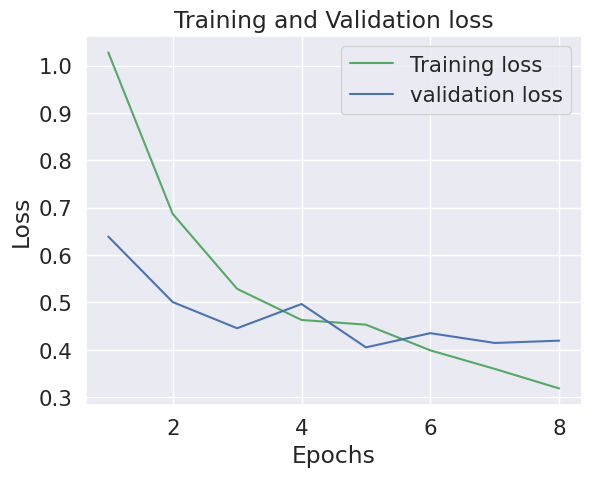

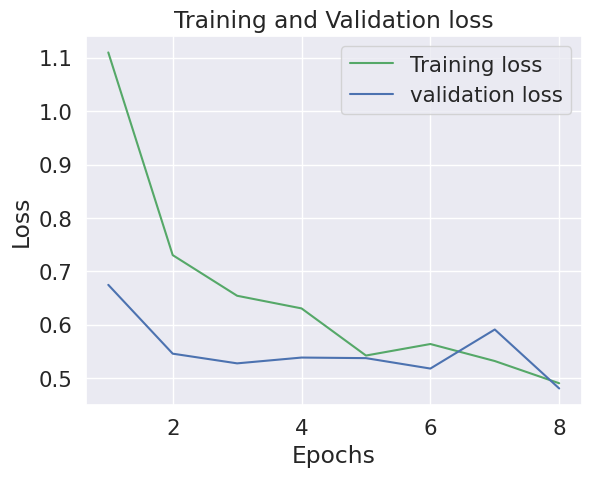

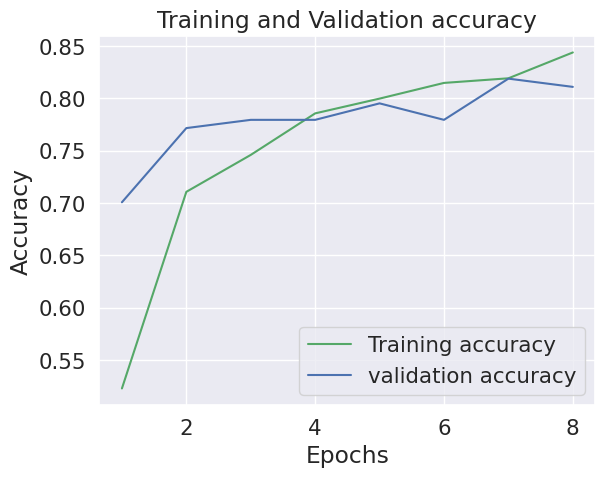

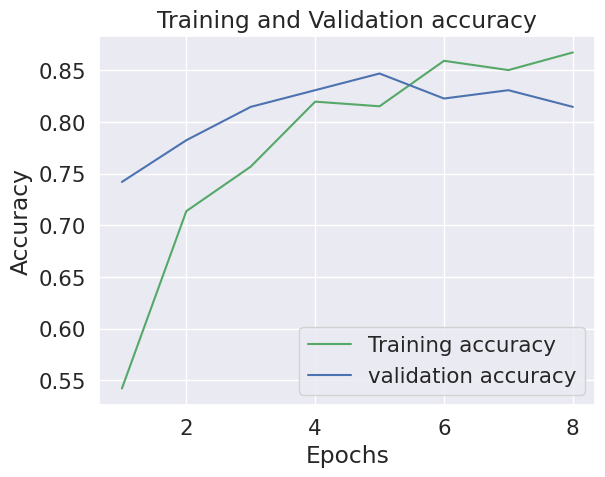

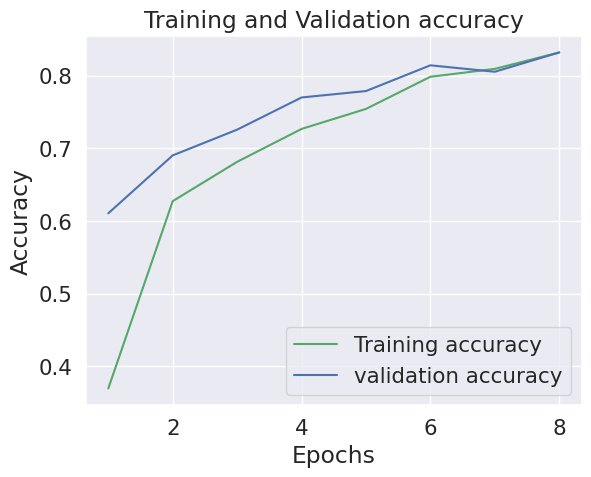

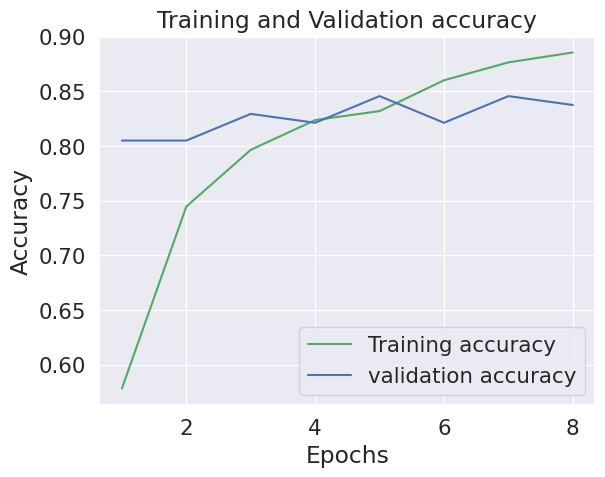

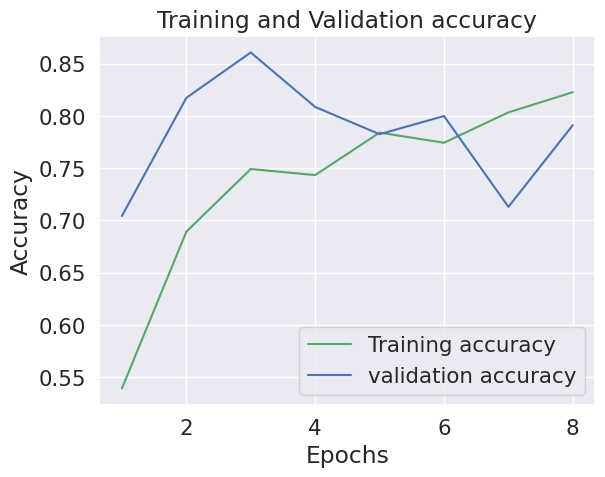

In [ ]:
draw_loss(history_combined,8)
draw_acc(history_combined,8)

In [ ]:
scores_combined = []
preds_combined = []
for i in range(5):
  scores_combined.append(models_combined[i].evaluate([Xs_vis_te[i], Xs_aud_te[i]],Ys_te[i]))
  preds_combined.append(models_combined[i].predict([Xs_vis_te[i], Xs_aud_te[i]]))

11/11 [==============================] - 2s 120ms/step


['ang', 'hap', 'neu', 'sad']


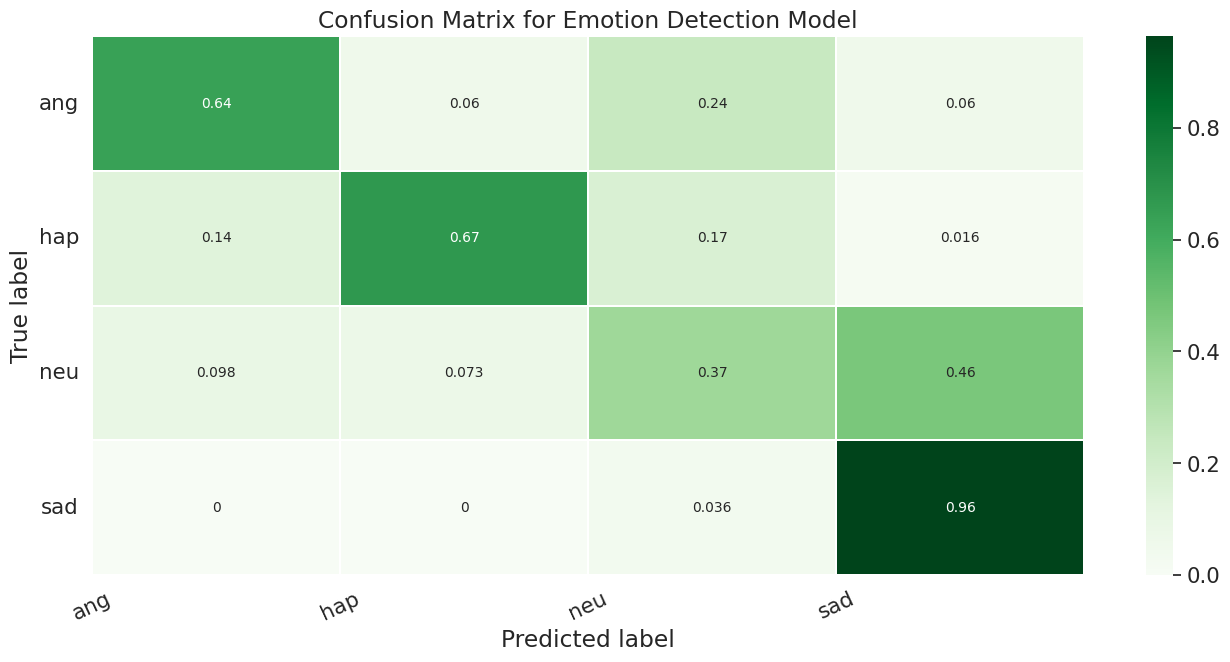

['ang', 'hap', 'neu', 'sad']


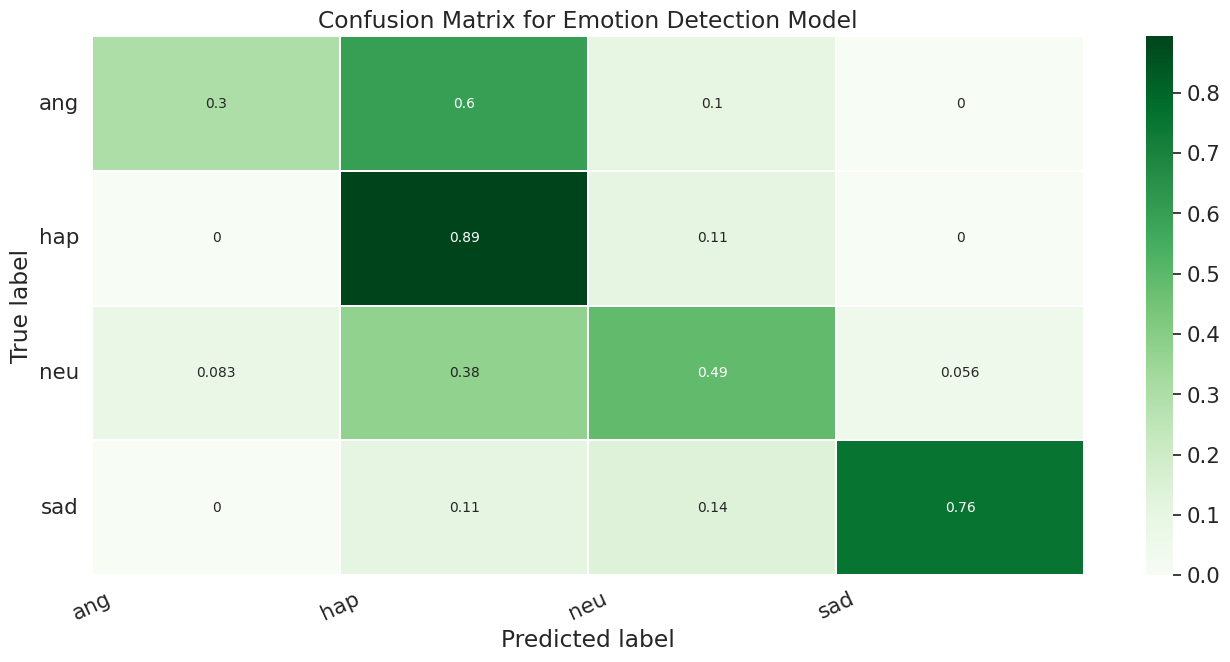

['ang', 'hap', 'neu', 'sad']


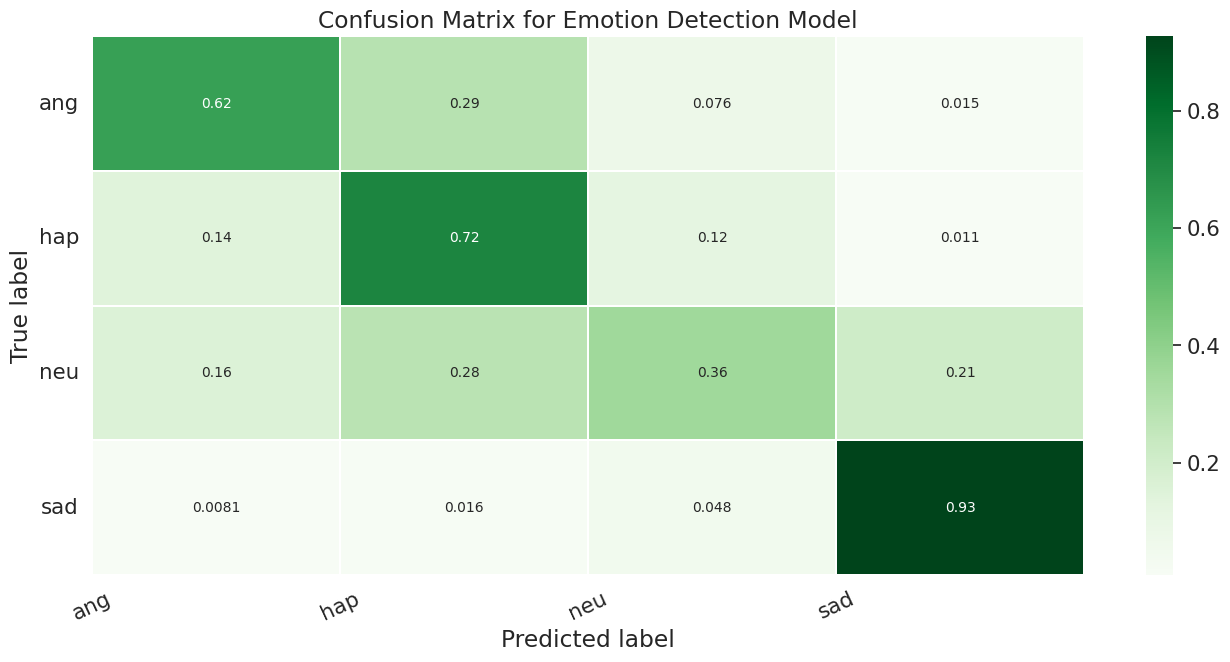

['ang', 'hap', 'neu', 'sad']


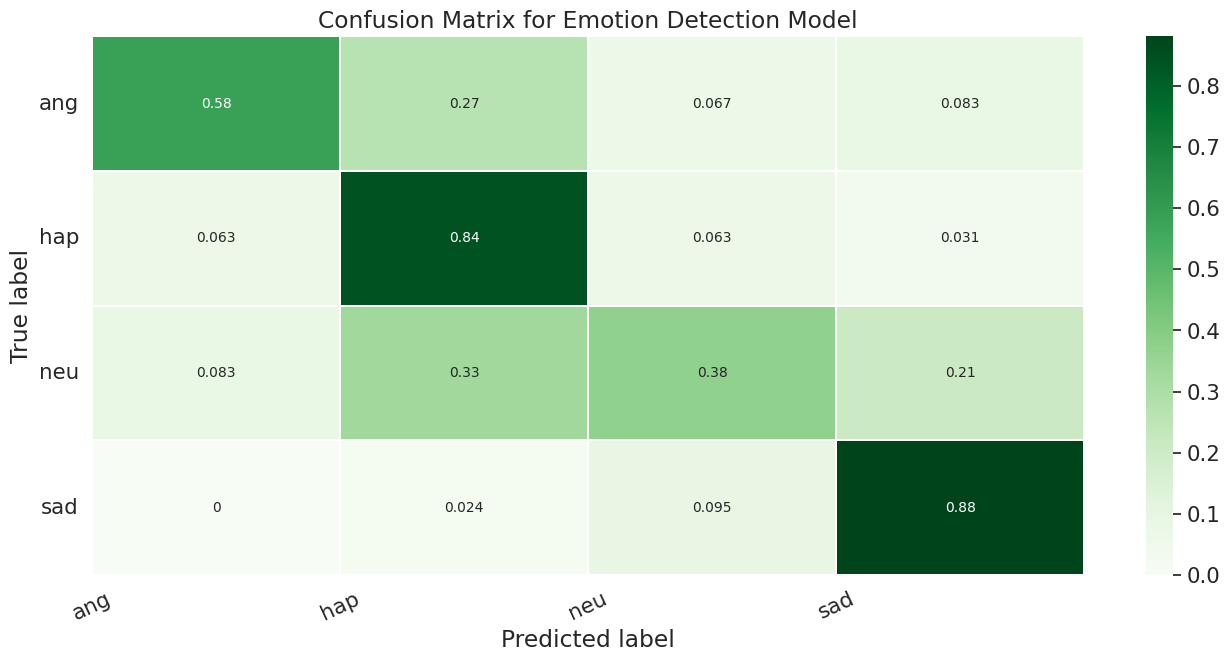

['ang', 'hap', 'neu', 'sad']


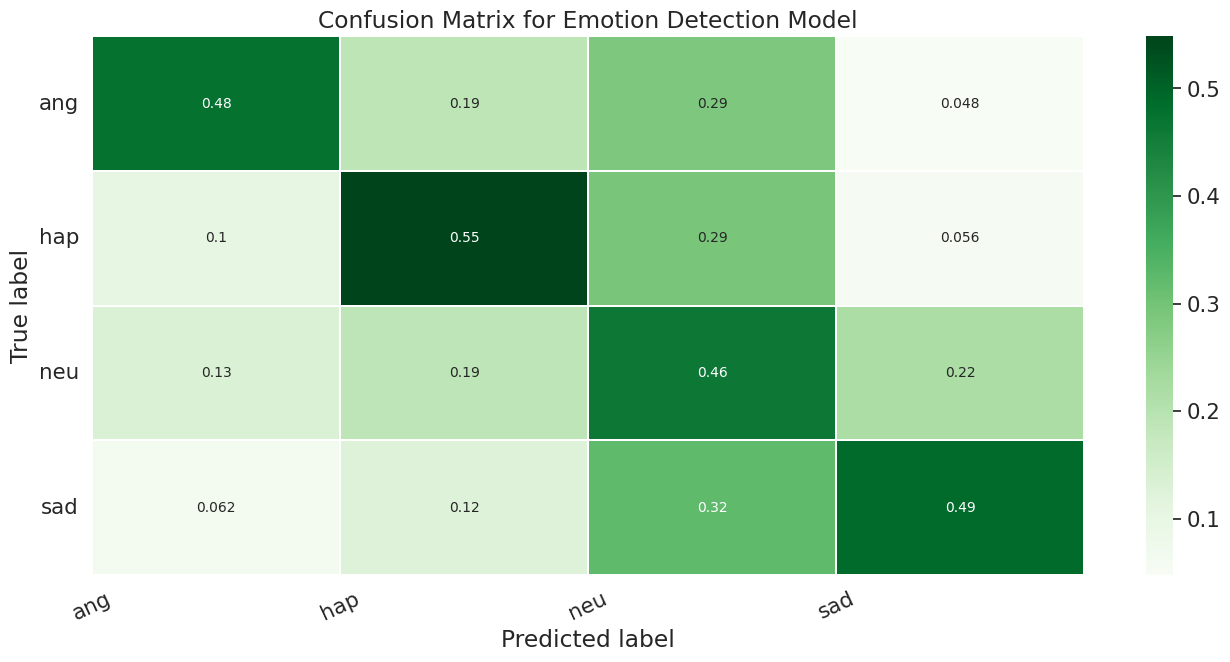

In [ ]:
for i in range(5):
  ploting_the_confusion_matrix(Ys_te[i], preds_combined[i], ['ang','hap','neu','sad'], unsupervised=False)

In [ ]:
def evalution_of_basic_ml(clf, X_test, Y_test, labels):
  Y_pred = clf.predict(X_test)
  print("test accurancy is: ", precision_recall_fscore_support(Y_test, Y_pred))
  ploting_the_confusion_matrix(Y_test, Y_pred, labels)

def ploting_the_confusion_matrix(y_test, y_pred_test, labels, unsupervised=True):
  # https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
  matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1))
  matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]


  # Build the plot
  plt.figure(figsize=(16,7))
  sns.set(font_scale=1.4)
  sns.heatmap(matrix, annot=True, annot_kws={'size':10},
              cmap=plt.cm.Greens, linewidths=0.2)
  print(labels)
  # Add labels to the plot
  class_names = labels
  tick_marks = np.arange(len(class_names))
  tick_marks2 = tick_marks + 0.5
  plt.xticks(tick_marks, class_names, rotation=25)
  plt.yticks(tick_marks2, class_names, rotation=0)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion Matrix for Emotion Detection Model')
  plt.show()

for i in range(5):
  ploting_the_confusion_matrix(Ys_te[i], preds_combined[i], ['ang','hap','neu','sad'], unsupervised=False)

In [ ]:
y_pred = model.predict(X_te)

In [ ]:
ploting_the_confusion_matrix(y_te, y_pred, ['ang','hap','neu','sad'], unsupervised=False)